## 1. Downloading the FG-NET Dataset

We first download the **FG-NET Aging Dataset** using `kagglehub`.  
This dataset contains facial images of individuals at different ages, which will be used for **age prediction** and **cross-age face matching**.


In [1]:
import kagglehub

# Download the latest version of the FG-NET dataset from Kaggle
path = kagglehub.dataset_download("aiolapo/fgnet-dataset")

# Print the local path where the dataset is saved
print("Path to dataset files:", path)


100%|██████████| 44.1M/44.1M [00:00<00:00, 187MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aiolapo/fgnet-dataset/versions/1


## 2. Copying the Dataset to the Working Directory

After downloading, we copy the FG-NET dataset from the Kaggle cache directory to the current working directory (`/content/fgnet-dataset`) for easier access.


In [2]:
!cp -r /root/.cache/kagglehub/datasets/aiolapo/fgnet-dataset/versions/1 /content/fgnet-dataset

## 3. Exploring the Dataset

Here we check the total number of images in the FG-NET dataset and display an example image.  
This step helps verify that the dataset is properly loaded and accessible.


Total Images: 1002


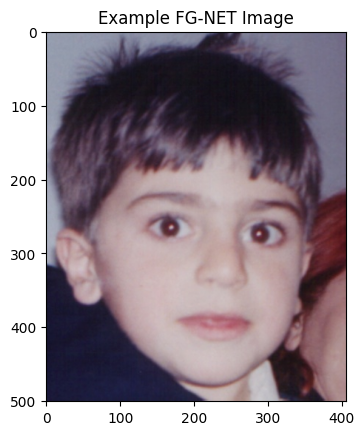

In [3]:
import os
import re
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the FG-NET images
images_path = "/content/fgnet-dataset/FGNET/images"

# Print the total number of images in the dataset
print("Total Images:", len(os.listdir(images_path)))

# Display an example image from the dataset to verify successful loading
img = cv2.imread(os.path.join(images_path, os.listdir(images_path)[0]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Example FG-NET Image")
plt.show()


## 4. Creating a DataFrame with Image Metadata

In this step, we extract essential metadata from the image filenames:

- **`person_id`** → The first 3 digits of the filename represent the unique individual ID.  
- **`age`** → Extracted from the pattern `A<number>` in the filename, representing the actual age of the person when the image was taken.

We then store all information in a Pandas DataFrame (`df_age`) with columns:  
`image`, `person_id`, `age`, and the full image `path`.

Finally, we display the top 20 individuals with the highest number of images to confirm proper extraction.


In [4]:
data = []

# Loop through all images in the dataset
for img_name in os.listdir(images_path):
    if img_name.lower().endswith(".jpg"):
        # Extract the first 3 digits as the person_id (unique identifier for each individual)
        person_id = re.match(r"(\d{3})", img_name).group(1)

        # Extract the age from the filename pattern "A<number>"
        age_match = re.search(r"A(\d+)", img_name, re.IGNORECASE)
        age = int(age_match.group(1)) if age_match else None

        # Append metadata to the list
        data.append([img_name, person_id, age])

# Create a DataFrame with image metadata
df_age = pd.DataFrame(data, columns=["image", "person_id", "age"])

# Add a full path column for easier image loading later
df_age["path"] = df_age["image"].apply(lambda x: os.path.join(images_path, x))

# Display the top 20 individuals with the most images
print(df_age["person_id"].value_counts().head(20))


person_id
076    18
077    16
073    16
048    16
074    16
002    16
078    16
012    15
008    15
001    15
065    15
039    14
079    14
047    14
080    14
072    14
035    14
011    14
040    14
038    14
Name: count, dtype: int64


## 5. Splitting the Dataset into Training and Validation Sets

We split the dataset into **training** (80%) and **validation** (20%) sets while maintaining a balanced age distribution:

- **`age_bins`** → Ages are grouped into bins (e.g., 0–5, 6–10, ..., 60–70) to ensure stratified sampling.  
- **`train_test_split`** → Stratification is applied based on `age_bins` to preserve the age distribution in both sets.

Finally, we print the number of samples in each set.


In [5]:
from sklearn.model_selection import train_test_split

# Create age bins for stratification to maintain balanced age distribution
df_age["age_bins"] = pd.cut(df_age["age"], bins=[-1,5,10,15,20,30,40,50,60,70], labels=False)

# Drop rows with missing age bins (if any)
df_age = df_age.dropna(subset=["age_bins"])

# Split the dataset into training (80%) and validation (20%)
train_df, val_df = train_test_split(
    df_age,
    test_size=0.2,
    random_state=42,
    stratify=df_age["age_bins"]  # Ensure balanced age distribution
)

print("Train:", len(train_df), "Validation:", len(val_df))


Train: 801 Validation: 201


## 6. Building the Age Prediction Model (Transfer Learning with ResNet50)

We use **Transfer Learning** with a pre-trained **ResNet50** (trained on ImageNet):

- **Feature Extractor (ResNet50)** → Pre-trained weights are used, and the first layers are frozen to retain low-level features.  
- **Fine-tuning** → The last 50 layers are unfrozen for fine-tuning on our dataset.  
- **Added Layers**:
  - `GlobalAveragePooling2D` → Reduces feature maps to a vector.
  - `Dense(256, relu)` → Fully connected layer for learning age-related features.
  - `Dropout(0.3)` → Reduces overfitting.
  - `Dense(1, linear)` → Single output neuron for regression (predicting age).

The model is compiled with:
- **Loss**: Mean Squared Error (MSE) (suitable for regression tasks).
- **Metric**: Mean Absolute Error (MAE) (easier to interpret as average age error).


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model (ImageNet weights) without the top classification layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last 50 for fine-tuning
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Add custom layers for age prediction (regression head)
x = GlobalAveragePooling2D()(base_model.output)       # Convert feature maps to a single vector
x = Dense(256, activation='relu')(x)                  # Fully connected layer for learning age-specific patterns
x = Dropout(0.3)(x)                                   # Dropout to reduce overfitting
output = Dense(1, activation='linear')(x)             # Single output neuron for age (regression)

# Build the final model
age_model = Model(inputs=base_model.input, outputs=output)

# Compile the model with regression-friendly settings
age_model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mae"])

# Display the model architecture
age_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 17,475,329 (66.66 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

## 7. Data Augmentation and Data Generators

To improve generalization and reduce overfitting, we apply **data augmentation** to the training set:

- **Rotation**: ±30°  
- **Width/Height Shifts**: Up to 20%  
- **Shear & Zoom**: Random geometric transformations  
- **Horizontal Flip**: Simulates mirrored faces  
- **Brightness Adjustment**: Between 70% and 130%  
- **Fill Mode**: Fills empty pixels with the nearest pixel values.

The validation set is only preprocessed (no augmentation) to ensure fair evaluation.

We then create two generators:
- **`train_gen`** → Feeds augmented batches to the model.
- **`val_gen`** → Feeds clean validation images.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define image size and batch size
img_size = (224, 224)
batch_size = 16

# Training data augmentation to improve generalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Required for ResNet preprocessing
    rotation_range=30,                        # Random rotations
    width_shift_range=0.2,                    # Horizontal shifts
    height_shift_range=0.2,                   # Vertical shifts
    shear_range=0.2,                          # Shearing transformations
    zoom_range=0.2,                           # Random zooms
    horizontal_flip=True,                     # Flipping images horizontally
    brightness_range=[0.7, 1.3],              # Brightness variation
    fill_mode="nearest"                       # Filling missing pixels after transformations
)

# Validation data (no augmentation, only preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training generator
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",      # Path to images
    y_col="age",       # Target variable (age)
    target_size=img_size,
    class_mode="raw",  # Regression mode (not classification)
    batch_size=batch_size
)

# Validation generator
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="age",
    target_size=img_size,
    class_mode="raw",
    batch_size=batch_size
)


Found 801 validated image filenames.
Found 201 validated image filenames.


## 8. Training the Age Prediction Model

We train the age prediction model for **30 epochs** using the augmented training data and validate it on the clean validation set.

- **Training Set (`train_gen`)** → Augmented images to improve generalization.  
- **Validation Set (`val_gen`)** → Used to monitor performance and detect overfitting.  

The training process records the **Loss (MSE)** and **MAE (Mean Absolute Error)** for both sets, stored in the `history` object for later visualization.


In [8]:
history = age_model.fit(train_gen, validation_data=val_gen, epochs=30)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 57s 620ms/step - loss: 222.2832 - mae: 10.9342 - val_loss: 82.1391 - val_mae: 6.0646
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step - loss: 63.5694 - mae: 5.9837 - val_loss: 109.7616 - val_mae: 7.4925
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - loss: 46.2806 - mae: 5.0647 - val_loss: 70.0191 - val_mae: 5.7429
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - loss: 39.9889 - mae: 4.6865 - val_loss: 48.8479 - val_mae: 5.0747
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - loss: 36.9105 - mae: 4.3353 - val_loss: 51.1301 - val_mae: 5.0043
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - loss: 31.9165 - mae: 4.1662 - val_loss: 38.4618 - val_mae: 4.3922
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - loss: 34.0069 - mae: 4.1199 - val_loss: 41.1143 - val_mae: 4.4672
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - loss: 33.6664 - mae: 4.3515 - val_loss: 41.0722 - val_mae: 4.4744
Epoch 9/30
51/51 ━━━━━━━━━━━━

In [21]:
age_model.save("age_model_resnet50.h5")
print("Model saved successfully!")


Model saved successfully!


## 9. Visualizing the Training Performance (Learning Curve - MAE)

We plot the **Mean Absolute Error (MAE)** for both training and validation sets across all epochs:

- A decreasing MAE on both sets indicates good learning.  
- This plot is crucial for evaluating how well the model generalizes to unseen data.


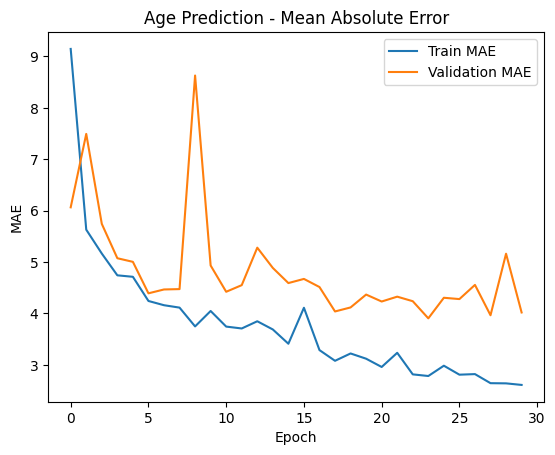

In [9]:
# Plot the training and validation Mean Absolute Error (MAE) over epochs
plt.plot(history.history["mae"], label="Train MAE")        # Training MAE curve
plt.plot(history.history["val_mae"], label="Validation MAE")  # Validation MAE curve
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Age Prediction - Mean Absolute Error")
plt.show()


## 10. Predicting Age for a Single Image

We define a helper function `predict_age()` that:

1. Loads and preprocesses an image to match the ResNet50 input requirements (224×224, normalized).  
2. Predicts the age using the trained `age_model`.  
3. Optionally displays the image with the predicted age as the title (`show=True`).  

Finally, we test the function on a single validation image and compare the **predicted age** with the **actual age**.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


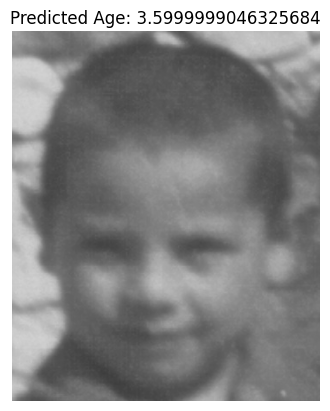

Predicted Age: 3.5999999046325684, Real Age: 5


In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def predict_age(img_path, show=True):
    # Load and preprocess the image for the model
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))

    # Predict the age (regression output)
    pred_age = age_model.predict(img_array)[0][0]
    pred_age = round(pred_age, 1)  # Round to 1 decimal place

    # Optionally display the image with the predicted age as a title
    if show:
        img_cv = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        plt.imshow(img_cv)
        plt.title(f"Predicted Age: {pred_age}")
        plt.axis("off")
        plt.show()

    return pred_age

# Test the function on one validation image
img_test = val_df.iloc[0]["path"]
pred = predict_age(img_test)
print(f"Predicted Age: {pred}, Real Age: {val_df.iloc[0]['age']}")


## 11. Creating Positive and Negative Image Pairs for Face Matching Evaluation

To evaluate the face matching model, we generate two types of pairs:

1. **Positive Pairs** → Two images of the **same person** (same `person_id`).  
2. **Negative Pairs** → Two images of **different people** (different `person_id`).  

The number of negative pairs is set equal to the number of positive pairs to maintain a balanced evaluation dataset.


In [10]:
import random

positive_pairs = []

# Group images by person_id to create positive pairs
grouped = df_age.groupby("person_id")

for pid, group in grouped:
    if len(group) > 1:
        imgs = group["path"].tolist()
        # Create all possible unique pairs for the same person
        pairs = [(imgs[i], imgs[j]) for i in range(len(imgs)) for j in range(i+1, len(imgs))]
        positive_pairs.extend(pairs)

# Create negative pairs (equal to the number of positive pairs)
all_paths = df_age["path"].tolist()
negative_pairs = []
for _ in range(len(positive_pairs)):
    img1, img2 = random.sample(all_paths, 2)
    # Ensure the two images belong to different people
    while df_age[df_age["path"] == img1]["person_id"].values[0] == df_age[df_age["path"] == img2]["person_id"].values[0]:
        img1, img2 = random.sample(all_paths, 2)
    negative_pairs.append((img1, img2))

print(f"Positive Pairs: {len(positive_pairs)}, Negative Pairs: {len(negative_pairs)}")


Positive Pairs: 5808, Negative Pairs: 5808


In [11]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a7ae5ae13fbe7c56b29395d0a828c6b0e9526e5cb50b45def4817c1f20eaca61
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


## 12. Face Matching Evaluation (Using DeepFace - Facenet512)

We evaluate the face matching performance using **DeepFace** with the **Facenet512** model:

1. **Distance Calculation** → For each pair, we compute the embedding distance using `DeepFace.verify()`.  
2. **Labels** → `1` for positive pairs (same person), `0` for negative pairs (different people).  
3. **Threshold** → If distance ≤ 0.4, images are classified as the same person.  
4. **Metrics**:
   - **Accuracy** → Percentage of correctly classified pairs.  
   - **ROC-AUC** → Area Under the ROC Curve, using `-distance` (since lower distance = higher similarity).

We evaluate on **500 positive** and **500 negative pairs** for faster computation.


In [13]:
from deepface import DeepFace
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

def get_distance(img1, img2, model="Facenet512"):
    # Compute the embedding distance between two images using DeepFace
    result = DeepFace.verify(img1, img2, model_name=model, enforce_detection=False)
    return result["distance"]

distances, labels = [], []

# Compute distances for positive pairs (same person) → label = 1
for img1, img2 in tqdm(positive_pairs[:500], desc="Positive Pairs"):
    distances.append(get_distance(img1, img2))
    labels.append(1)

# Compute distances for negative pairs (different people) → label = 0
for img1, img2 in tqdm(negative_pairs[:500], desc="Negative Pairs"):
    distances.append(get_distance(img1, img2))
    labels.append(0)

# Classification based on a fixed threshold
threshold = 0.4
preds = [1 if d <= threshold else 0 for d in distances]

# Evaluate performance
acc = accuracy_score(labels, preds)
roc_auc = roc_auc_score(labels, [-d for d in distances])  # Use -distance since lower = more similar

print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")


25-07-21 21:06:08 - Directory /root/.deepface has been created
25-07-21 21:06:08 - Directory /root/.deepface/weights has been created


Positive Pairs:   0%|          | 0/500 [00:00<?, ?it/s]

25-07-21 21:06:10 - facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5

  0%|          | 0.00/95.0M [00:00<?, ?B/s]
 12%|█▏        | 11.0M/95.0M [00:00<00:00, 85.4MB/s]
 25%|██▌       | 24.1M/95.0M [00:00<00:00, 109MB/s] 
 38%|███▊      | 35.7M/95.0M [00:00<00:00, 110MB/s]
 52%|█████▏    | 49.8M/95.0M [00:00<00:00, 122MB/s]
 67%|██████▋   | 63.4M/95.0M [00:00<00:00, 110MB/s]
 80%|███████▉  | 75.5M/95.0M [00:00<00:00, 113MB/s]
100%|██████████| 95.0M/95.0M [00:00<00:00, 109MB/s]
Negative Pairs: 100%|██████████| 500/500 [11:38<00:00,  1.40s/it]

Accuracy: 0.755
ROC-AUC: 0.936


## 13. ROC Curve for Face Matching Performance

We plot the **ROC (Receiver Operating Characteristic) Curve** to visualize the trade-off between the **True Positive Rate (TPR)** and **False Positive Rate (FPR)**:

- **ROC-AUC**: The area under the curve; values closer to 1 indicate excellent face matching performance.  
- **Diagonal Line (k--)**: Represents random guessing (baseline).

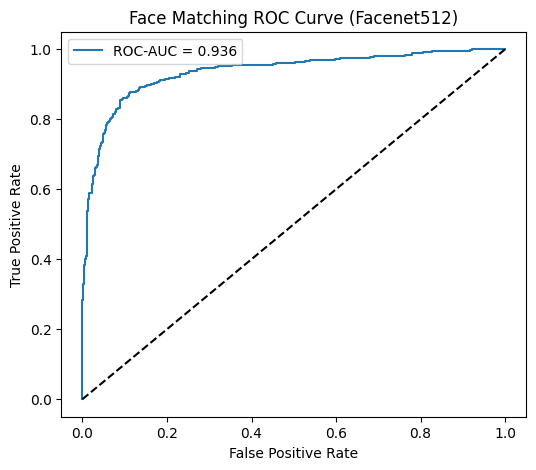

In [14]:
# Compute ROC curve points
fpr, tpr, _ = roc_curve(labels, [-d for d in distances])  # Use -distance because higher similarity = better match

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")  # ROC curve with AUC score
plt.plot([0, 1], [0, 1], 'k--')  # Baseline (random guessing)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Face Matching ROC Curve (Facenet512)")
plt.legend()
plt.show()


## 14. Full Inference: Age Prediction + Face Matching

We define a **complete inference pipeline** that combines both tasks:

1. **Age Prediction** → Predicts the age for both input images using the trained `age_model`.  
2. **Face Matching** → Uses `DeepFace` (Facenet512) to calculate the distance between embeddings and classify if both images belong to the same person (`threshold=0.4`).  
3. **Visualization** → Displays both images side by side with their predicted ages, and the title shows whether they are classified as the same person along with the matching distance.

Finally, we test the pipeline using two sample images from the dataset.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


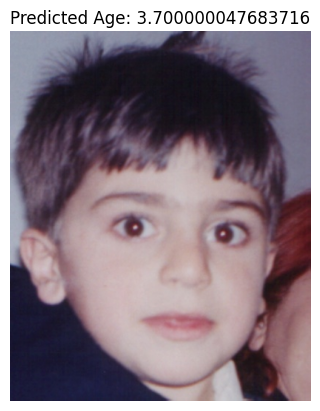

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


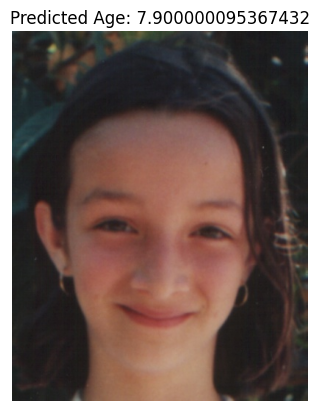

Image1 Age: 3.700000047683716, Image2 Age: 7.900000095367432
Same Person? False (Distance=0.881)


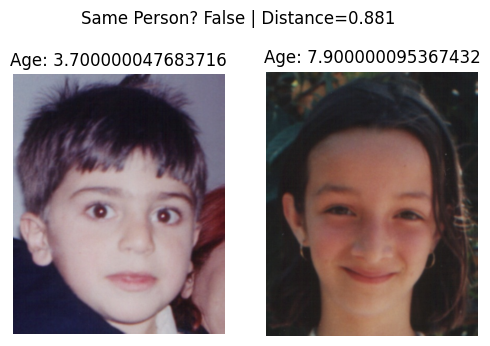

(np.float32(3.7), np.float32(7.9), 0.8810330640555336, False)

In [15]:
import matplotlib.pyplot as plt
import cv2

def face_matching_inference(img1_path, img2_path, model="Facenet512", threshold=0.4):
    """
    Compare two images using DeepFace (Facenet512).
    Returns the embedding distance and whether they are classified as the same person.
    """
    result = DeepFace.verify(img1_path, img2_path, model_name=model, enforce_detection=False)
    distance = result["distance"]
    same_person = distance <= threshold
    return distance, same_person

def full_inference(img1, img2):
    """
    Perform full inference:
    1. Predict ages for both images.
    2. Perform face matching.
    3. Print results and display the two images side by side.
    """
    # Age Prediction
    age1 = predict_age(img1)
    age2 = predict_age(img2)

    # Face Matching
    dist, same = face_matching_inference(img1, img2)

    # Print Results
    print(f"Image1 Age: {age1}, Image2 Age: {age2}")
    print(f"Same Person? {same} (Distance={dist:.3f})")

    # Show Images Side by Side with predicted ages
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    for ax, img_path, title in zip(
        axes,
        [img1, img2],
        [f"Age: {age1}", f"Age: {age2}"]
    ):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")

    plt.suptitle(f"Same Person? {same} | Distance={dist:.3f}")
    plt.show()

    return age1, age2, dist, same

# Test the full pipeline on two sample images
img1 = df_age.iloc[0]["path"]
img2 = df_age.iloc[10]["path"]
full_inference(img1, img2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


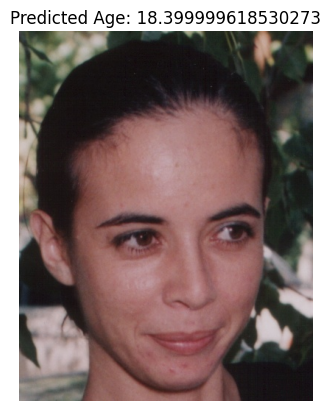

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


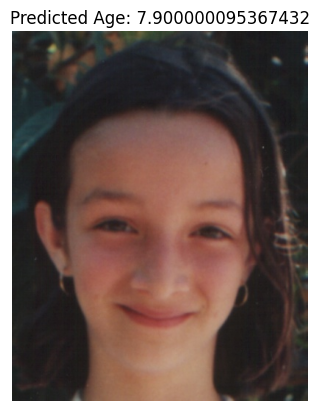

Image1 -> Real Age: 30, Predicted Age: 18.399999618530273
Image2 -> Real Age: 10, Predicted Age: 7.900000095367432
Same Person? False (Distance=0.839)


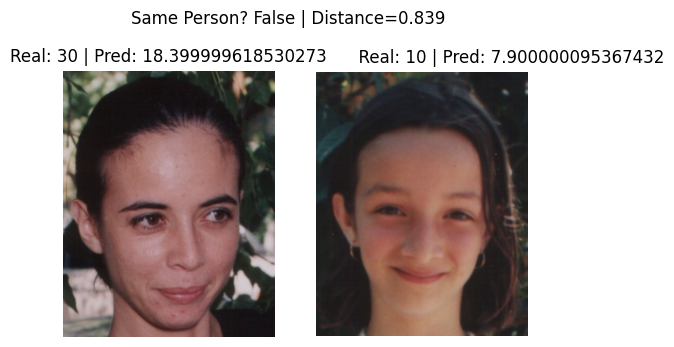

((np.int64(30), np.float32(18.4)),
 (np.int64(10), np.float32(7.9)),
 0.8388890673386632,
 False)

In [24]:
import matplotlib.pyplot as plt
import cv2

def face_matching_inference(img1_path, img2_path, model="Facenet512", threshold=0.4):
    result = DeepFace.verify(img1_path, img2_path, model_name=model, enforce_detection=False)
    distance = result["distance"]
    same_person = distance <= threshold
    return distance, same_person

def full_inference(img1, img2):
    # Predicted Ages
    age1_pred = predict_age(img1)
    age2_pred = predict_age(img2)

    age1_real = df_age[df_age["path"] == img1]["age"].values[0]
    age2_real = df_age[df_age["path"] == img2]["age"].values[0]

    # Face Matching
    dist, same = face_matching_inference(img1, img2)

    # Print Results
    print(f"Image1 -> Real Age: {age1_real}, Predicted Age: {age1_pred}")
    print(f"Image2 -> Real Age: {age2_real}, Predicted Age: {age2_pred}")
    print(f"Same Person? {same} (Distance={dist:.3f})")

    # Show Images Side by Side
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    for ax, img_path, title in zip(
        axes,
        [img1, img2],
        [
            f"Real: {age1_real} | Pred: {age1_pred}",
            f"                                  Real: {age2_real} | Pred: {age2_pred}"
        ]
    ):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")

    plt.suptitle(f"Same Person? {same} | Distance={dist:.3f}")
    plt.show()

    return (age1_real, age1_pred), (age2_real, age2_pred), dist, same


img1 = df_age.iloc[2]["path"]
img2 = df_age.iloc[10]["path"]
full_inference(img1, img2)


## 15. Validation on Two Images of the Same Person

To validate the face matching system, we select two images of the **same person**:

1. We pick the person with the highest number of available images (`person_id` with max count).  
2. We run the `full_inference()` function to check if:
   - The predicted ages are reasonable.
   - The face matching model correctly classifies them as the same person (distance ≤ 0.4).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


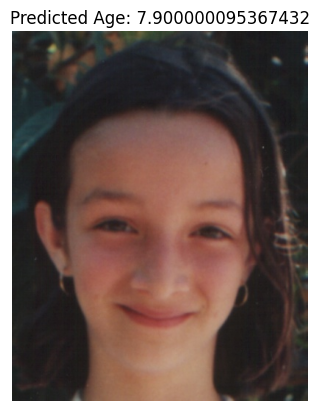

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


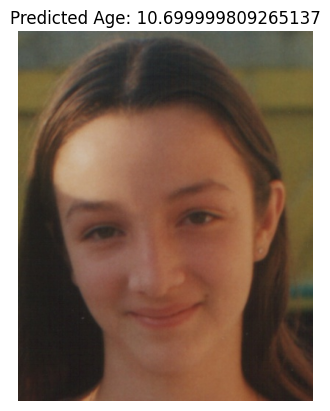

Image1 -> Real Age: 10, Predicted Age: 7.900000095367432
Image2 -> Real Age: 13, Predicted Age: 10.699999809265137
Same Person? True (Distance=0.297)


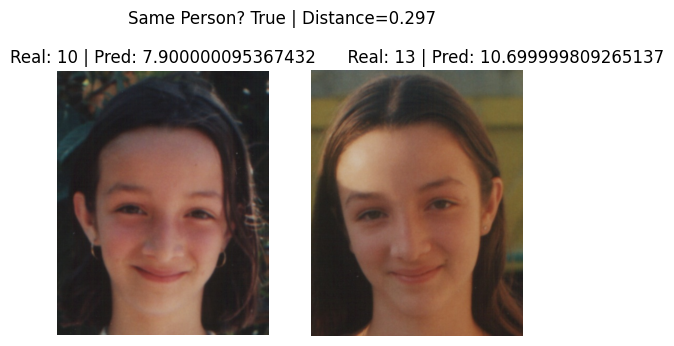

((np.int64(10), np.float32(7.9)),
 (np.int64(13), np.float32(10.7)),
 0.29682466152309106,
 True)

In [25]:
# Select the person with the maximum number of available images
same_person_group = df_age[df_age["person_id"] == df_age["person_id"].value_counts().idxmax()]

# Pick two different images of the same person
img1 = same_person_group.iloc[0]["path"]
img2 = same_person_group.iloc[1]["path"]

# Run the full inference (age prediction + face matching)
full_inference(img1, img2)
